In [2]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import praw
sns.set(style='darkgrid', context='talk', palette='Dark2')

# Sentiment Analysis on r/CryptoCurrency

As crypto markets tumble, lets use NTLK to detect sentiment on popular subreddit r/CryptoCurrency

Link: https://www.reddit.com/r/CryptoCurrency/

Will be scarpping the "Hottest " posts using praw - *note* we are limited to 1000 posts only

Tutorial Reference: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

In [3]:
reddit = praw.Reddit(client_id='##',
                     client_secret='##',
                     user_agent='##')

Query *r/CryptoCurrency* "Hot" posts and store headlines in Set object. 

Output the number of headlines queried (<1000)

In [4]:
headlines = set()

for submission in reddit.subreddit('CryptoCurrency').hot(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

671


Iterate through headlines and apply *polarity_scores* to gauge sentiment

- **neg** : Negative
- **neu** : Neutral
- **pos** : Positive
- **compound** : Aggregate score


In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.1779,
  'headline': 'Amazon Marketplace Owners Can Now Be Bought Out in Crypto',
  'neg': 0.0,
  'neu': 0.841,
  'pos': 0.159},
 {'compound': 0.0,
  'headline': 'Are any cryptos still “untraceable”',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.4019,
  'headline': 'Crypto Tax Software Firm CoinTracker Raises $100M to Help Traders Prep for IRS',
  'neg': 0.0,
  'neu': 0.816,
  'pos': 0.184}]


Convert to DataFrame for EDA

In [6]:
df = pd.DataFrame.from_records(results)
df.describe()

,neg,neu,pos,compound
count,671.000000,671.000000,671.000000,671.000000
mean,0.061624,0.850770,0.087601,0.041465
std,0.122014,0.164493,0.129112,0.328926
min,0.000000,0.222000,0.000000,-0.922900
25%,0.000000,0.745500,0.000000,0.000000
50%,0.000000,0.882000,0.000000,0.000000
75%,0.078500,1.000000,0.162000,0.214400
max,0.767000,1.000000,0.778000,0.918600


Set thresholds on compound score: 

 - Compound > 0.2 $\Rightarrow$ Positive
 - Compound < -0.2 $\Rightarrow$ Negative
 - -0.2 < Compound < 0.2 $\Rightarrow$  Neutral

In [7]:
df['result'] = "Neutral"
df.loc[df['compound'] > 0.2, 'result'] = "Postive"
df.loc[df['compound'] < -0.2, 'result'] = "Negative"
df.head()

,neg,neu,pos,compound,headline,result
0,0.000,0.841,0.159,0.1779,Amazon Marketplace Owners Can Now Be Bought Ou...,Neutral
1,0.000,1.000,0.000,0.0000,Are any cryptos still “untraceable”,Neutral
2,0.000,0.816,0.184,0.4019,Crypto Tax Software Firm CoinTracker Raises $1...,Postive
3,0.000,1.000,0.000,0.0000,Invested in land Sandbox,Neutral
4,0.259,0.741,0.000,-0.2732,e SEC has blocked Anthony Scaramucci's Bitcoin...,Negative


## Sentiment Barplot

<AxesSubplot:ylabel='result'>

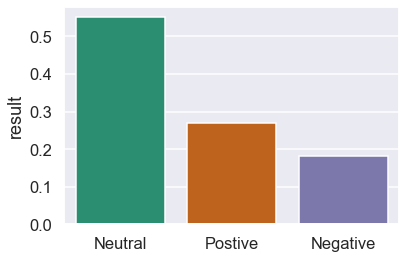

In [8]:
counts = df.result.value_counts(normalize=True)
sns.barplot(x=counts.index, y=counts)

In [10]:
print("Positive headlines:\n")
pprint(list(df[df['result'] == "Postive"].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['result'] == "Negative"].headline)[:5], width=200)

Positive headlines:

['Crypto Tax Software Firm CoinTracker Raises $100M to Help Traders Prep for IRS',
 'Digital Currency Group announces $10M investment in Railgun, a Layer-1 privacy solution for Ethereum',
 "What's The Best Coin To Stake?",
 'OK, PANIC over. You can relax. Maybe even buy some bitcoin.',
 'Putin Comments Revive Hope For Cryptocurrencies In Russia']

Negative headlines:

["e SEC has blocked Anthony Scaramucci's Bitcoin ETF",
 "SEC rejects Fidelity's proposed spot Bitcoin ETF",
 'Bounce or more pain? Macroexpert gives his opinion.',
 '30,000 Bitcoin Millionaires Vanish After Crypto Crash - Nah, they just changed their status for a short while!',
 'Zombie Atari Shits On 50-Year Legacy With NFT Loot Boxes']
